In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time


In [6]:
def cross_in_func(pop,*kwargs):
    # kwargs 
    # first: linear, sigmoid 1 or 2...
    # second: x0
    # third: a
    # fouth: make superior part of the sigmoid linear (True) or not
    if not kwargs or kwargs[0] == 0 or kwargs[0] == 'lin':
        return pop
    elif kwargs[0] == 1 or kwargs[0] == 'sigmoid1':
        x0, a = kwargs[1], kwargs[2]
        cival = 1/(1+np.exp(-a*(pop-x0))) 
        if len(kwargs) == 4 and kwargs[3]:
            cival = min(cival, pop)
        return cival
    elif kwargs[0] == 2 or kwargs[0] == 'sigmoid2':
        x0, a = kwargs[1], kwargs[2]
        return 2*pop/(1+np.exp(-a*(pop-x0)))

def fs_evo_eq(t,fs,pis,qs,l,lci,ci_kwargs=[0, ]):
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i] #- lci*fs[site_i]*(sum(fs[1:site_i])+sum(fs[site_i+1:]))
        for j in range(len(fs)-1):
            site_j = j+1
            if site_j != site_i:
                dfdt += -lci*fs[site_i]*cross_in_func(fs[site_j],*ci_kwargs)
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

# LINES TO EVALUATE PERFORMANCE
# start_time = time.time()
# for _ in range(100):
#     sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci), method='RK23') # dense_output=True
# print("--- %s seconds ---" % (time.time() - start_time))

In [3]:
fs0 = [1.0, 0.0, 0.0]
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.6, 0.6

# No Cross inhibition:
sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, 0.0))
print(f'NO Cross-inhibition: {sol.y[0][-1]}, {sol.y[1][-1]}, {sol.y[2][-1]}')

# Linear Cross inhibition:
sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci))
print(f'Linear Cross-inhibition: {sol.y[0][-1]}, {sol.y[1][-1]}, {sol.y[2][-1]}')

# Sigmoid1 Cross-inhibition:
ci_kwargs = [1, 0.8, 40]
sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci, ci_kwargs))
print(f'Sigmoid1 Cross-inhibition: {sol.y[0][-1]}, {sol.y[1][-1]}, {sol.y[2][-1]}')


NO Cross-inhibition: 0.14952431576106687, 0.2773297167193627, 0.573145967519569
Linear Cross-inhibition: 0.16635040808426724, 0.013217886194390887, 0.8204317057213408
Sigmoid1 Cross-inhibition: 0.14941703940542198, 0.27664468977853574, 0.5739382708160413


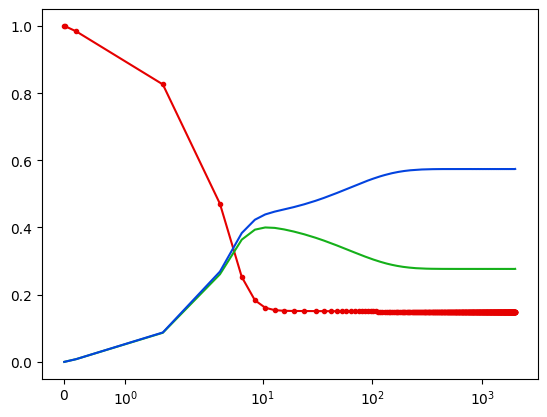

In [4]:
fig, ax = plt.subplots()
ax.set(xscale='symlog')
ax.plot(sol.t, sol.y[0], color='xkcd:red', marker='.')
ax.plot(sol.t, sol.y[1], color='xkcd:green')
ax.plot(sol.t, sol.y[2], color='xkcd:blue')

## Fix lambda', vary lambda

In [23]:
lcis = [0.1, 0.3, 0.6, 0.9]
ls = np.arange(0.0, 1.0, 0.05)

lcis_l_evo = {}
for lci in lcis:
    lcis_l_evo[lci] = {'lin':{'f2':[], 'Q':[], 'Qsimple':[]}, 'sig1':{'f2':[], 'Q':[], 'Qsimple':[]}}
    for l in ls:
        # linear cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci))
        lcis_l_evo[lci]['lin']['f2'].append(sol.y[2][-1])
        lcis_l_evo[lci]['lin']['Q'].append(sol.y[2][-1]-2*sol.y[1][-1])
        lcis_l_evo[lci]['lin']['Qsimple'].append(sol.y[2][-1]-sol.y[1][-1])
        # sigmoid cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci, [1, 0.35, 40, 1]))
        lcis_l_evo[lci]['sig1']['f2'].append(sol.y[2][-1])
        lcis_l_evo[lci]['sig1']['Q'].append(sol.y[2][-1]-2*sol.y[1][-1])
        lcis_l_evo[lci]['sig1']['Qsimple'].append(sol.y[2][-1]-sol.y[1][-1])

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_31152/2205214336.py:11: RuntimeWarning: overflow encountered in exp
  cival = 1/(1+np.exp(-a*(pop-x0)))


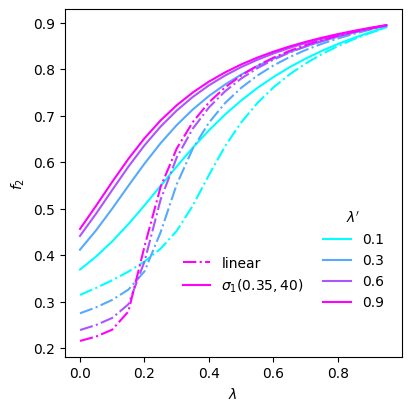

In [24]:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
mag, maglabel = 'f2', '$f_2$'
# mag, maglabel= 'Q', '$Q$'
# mag, maglabel= 'Qsimple', '$Q_1$'
ax.set(xlabel="$\lambda$", ylabel=maglabel)
colors = plt.cm.cool(np.linspace(0.0, 1.0, len(lcis)))

for (lci,l_evo),c in zip(lcis_l_evo.items(),colors):
    ax.plot(ls, l_evo['lin'][mag], ls='-.', color=c)
    ax.plot(ls, l_evo['sig1'][mag], ls='-', color=c, label=f'{lci}')

ax.legend(title="$\lambda'$", frameon=False, loc=(0.75,0.12))

ax2 = fig.add_axes((1,1,1,1))
ax2.set_visible(False)
ax2.plot(lcis, lcis, ls='-.', color=colors[-1], label='linear')
ax2.plot(lcis, lcis, ls='-', color=colors[-1], label='$\sigma_1 (0.35, 40)$')
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc=(0.43, 0.27))

# fig.savefig(f'x_lambda_y_{mag}_ci_num_int_compare_lin_sig1.png')
fig.savefig(f'x_lambda_y_{mag}_ci_num_int_compare_lin_sig1supLin.png')

## Fix lambda, vary lambda'

In [25]:
ls = [0.1, 0.3, 0.6, 0.9]
lcis = np.arange(0.0, 1.0, 0.05)

ls_lci_evo = {}
for l in ls:
    ls_lci_evo[l] = {'lin':{'f2':[], 'Q':[], 'Qsimple':[]}, 'sig1':{'f2':[], 'Q':[], 'Qsimple':[]}}
    # lci_evo = {'lin':[], 'sig1':[]}
    for lci in lcis:
        # linear cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci))
        ls_lci_evo[l]['lin']['f2'].append(sol.y[2][-1])
        ls_lci_evo[l]['lin']['Q'].append(sol.y[2][-1]-2*sol.y[1][-1])
        ls_lci_evo[l]['lin']['Qsimple'].append(sol.y[2][-1]-sol.y[1][-1])
        # sigmoid cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci, [1, 0.35, 40, 1]))
        ls_lci_evo[l]['sig1']['f2'].append(sol.y[2][-1])
        ls_lci_evo[l]['sig1']['Q'].append(sol.y[2][-1]-2*sol.y[1][-1])
        ls_lci_evo[l]['sig1']['Qsimple'].append(sol.y[2][-1]-sol.y[1][-1])


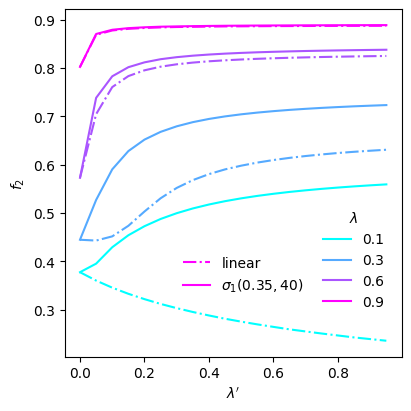

In [26]:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
mag, maglabel= 'f2', '$f_2$'
# mag, maglabel= 'Q', '$Q$'
ax.set(xlabel="$\lambda'$", ylabel=maglabel)
colors = plt.cm.cool(np.linspace(0.0, 1.0, len(ls)))

for (l,lci_evo),c in zip(ls_lci_evo.items(),colors):
    ax.plot(lcis, lci_evo['lin'][mag], ls='-.', color=c)
    ax.plot(lcis, lci_evo['sig1'][mag], ls='-', color=c, label=f'{l}')

ax.legend(title='$\lambda$', frameon=False, loc=(0.75,0.12))

ax2 = fig.add_axes((1,1,1,1))
ax2.set_visible(False)
ax2.plot(lcis, lcis, ls='-.', color=colors[-1], label='linear')
ax2.plot(lcis, lcis, ls='-', color=colors[-1], label='$\sigma_1 (0.35, 40)$')
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc=(0.43, 0.27))

# fig.savefig(f'x_lambdaci_y_{mag}_ci_num_int_compare_lin_sig1.png')
fig.savefig(f'x_lambdaci_y_{mag}_ci_num_int_compare_lin_sig1supLin.png')
# fig.savefig('ci_num_int_compare_lin_sig1_lci_evo_f2.png')

## Stationary times

In [18]:
def evoTimeDeriv(sol, getFullEvo=False, getStatTime=True, thresh=1e-4):
    evo_derivs = []
    for j in range(len(sol.y)):
        if getFullEvo:
            dfj = []
        if getStatTime:
            statTimej = []
        for i in range(len(sol.t)):
            if i == 0: # forward derivative at timestep 0
                deriv = (sol.y[j][1]-sol.y[j][0])/(sol.t[1]-sol.t[0])
            elif i == len(sol.t)-1: # backwards derivative at the last timestep
                deriv = (sol.y[j][-1]-sol.y[j][-2])/(sol.t[-1]-sol.t[-2])
            else: # central derivative at the last point
                deriv = 0.5*(sol.y[j][i+1]-sol.y[j][i-1])/(sol.t[i+1]-sol.t[i-1])
            if getFullEvo:
                dfj.append(deriv)
            if getStatTime:
                if deriv <= thresh and sol.t[i] >= 10:
                    statTimej.append(sol.t[i])
                    break
        if getFullEvo:
            evo_derivs.append(dfj)
    if getFullEvo:
        return evo_derivs
    if getStatTime:
        return max(statTimej)

In [27]:
# Fixing l and varying lci:
ls = [0.1, 0.3, 0.6, 0.9]
lcis = np.arange(0.0, 1.0, 0.05)

ls_lci_evo_times = {}
for l in ls:
    ls_lci_evo_times[l] = {'lin':[], 'sig1':[]}
    for lci in lcis:
        # linear cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 1000], fs0, args=(pis, qs, l, lci))
        statTime = evoTimeDeriv(sol)
        ls_lci_evo_times[l]['lin'].append(statTime)
        # sigmoid cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 1000], fs0, args=(pis, qs, l, lci, [1, 0.35, 40, 1]))
        statTime = evoTimeDeriv(sol)
        ls_lci_evo_times[l]['sig1'].append(statTime)

# Fixing lci and varying l:
# lcis = [0.1, 0.3, 0.6, 0.9]
# ls = np.arange(0.0, 1.0, 0.05)

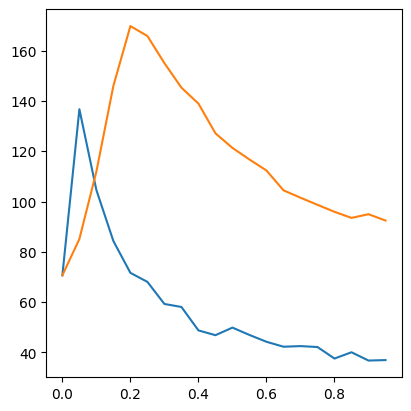

In [34]:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

ax.plot(lcis, ls_lci_evo_times[0.3]['sig1'])
ax.plot(lcis, ls_lci_evo_times[0.3]['lin'])


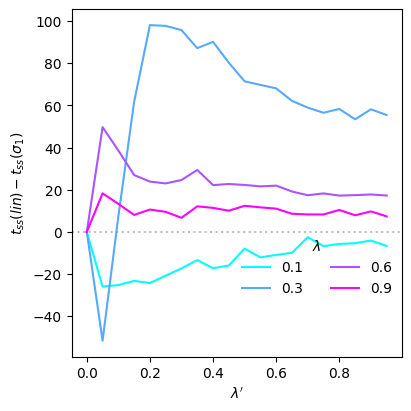

In [30]:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
colors = plt.cm.cool(np.linspace(0.0, 1.0, len(ls)))

### PLOT the times, simple
# ax.set(xlabel="$\lambda'$", ylabel=r'$t_{ss}$')
# for (l,lci_evo),c in zip(ls_lci_evo_times.items(),colors):
#     ax.plot(lcis, lci_evo['lin'], ls='-.', color=c)
#     ax.plot(lcis, lci_evo['sig1'], ls='-', color=c, label=f'{l}')

### PLOT time(linear)-time(sigmoid)
relative = False
if relative:
    ax.set(xlabel="$\lambda'$", ylabel=r'$1 - t_{ss}(\sigma_1)/t_{ss}(lin)$')
else:
    ax.set(xlabel="$\lambda'$", ylabel=r'$t_{ss}(lin) - t_{ss}(\sigma_1)$')
for (l,lci_evo),c in zip(ls_lci_evo_times.items(),colors):
    if relative:
        tdifRel = [abs(tlin-tsig)/tlin for tlin,tsig in zip(lci_evo['lin'], lci_evo['sig1'])]
        ax.plot(lcis, tdifRel, color=c, label=f'{l}')
    else:
        tdif = [tlin-tsig for tlin,tsig in zip(lci_evo['lin'], lci_evo['sig1'])]
        ax.plot(lcis, tdif, color=c, label=f'{l}')
    # add a mark to indicate the time of the no cross inhibition model
    # ax.axhline(lci_evo['lin'][0], 0.0, 0.2, ls=':', color=c, alpha=0.6)
ax.axhline(0.0, 0, 1, ls=':', color='xkcd:gray', alpha=0.6)
# ax.legend(title='$\lambda$', frameon=False, loc=(0.5,0.78), ncol=2)
ax.legend(title='$\lambda$', frameon=False, loc=(0.5,0.16), ncol=2)


# ax2 = fig.add_axes((1,1,1,1))
# ax2.set_visible(False)
# ax2.plot(lcis, lcis, ls='-.', color=colors[-1], label='linear')
# ax2.plot(lcis, lcis, ls='-', color=colors[-1], label='$\sigma_1 (0.35, 40)$')
# handles, labels = ax2.get_legend_handles_labels()
# fig.legend(handles, labels, frameon=False, loc=(0.43, 0.27))

supLinLabel = '_supLin'
# supLinLabel = ''

relLabel = '_rel' if relative else ''
fig.savefig(f'ci_num_int_compare_tss_lin{relLabel}_sig1{supLinLabel}_lci_evo.png')

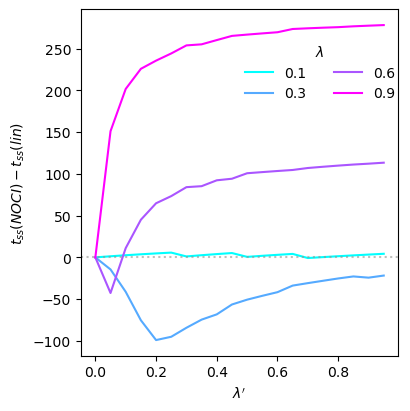

In [127]:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
lcis = np.arange(0.0, 1.0, 0.05)
colors = plt.cm.cool(np.linspace(0.0, 1.0, len(ls_lci_evo_times.keys())))

### PLOT time(NO CI)-time(sigmoid)
ax.set(xlabel="$\lambda'$", ylabel=r'$t_{ss}(NO CI) - t_{ss}(lin)$')
# ax.set(xlabel="$\lambda'$", ylabel=r'$t_{ss}(NO CI) - t_{ss}(\sigma_1)$')
for (l,lci_evo),c in zip(ls_lci_evo_times.items(),colors):
    t0 = lci_evo['lin'][0]
    tdif = [t0-tlin for tlin in lci_evo['lin']]
    # tdif = [t0-tsig for tsig in lci_evo['sig1']]
    ax.plot(lcis, tdif, color=c, label=f'{l}')

ax.axhline(0.0, 0, 1, ls=':', color='xkcd:gray', alpha=0.6)
ax.legend(title='$\lambda$', frameon=False, loc=(0.5,0.72), ncol=2)

fig.savefig('x_lambdaci_y_tssDifNoCIlin_num_int.png')
# fig.savefig('x_lambdaci_y_tssDifNoCIsig1_num_int.png')